In [1]:
import numpy as np
import os
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt


In [2]:
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))
    
    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)
        
    return np.array(frames)

def load_dataset(base_path):
    train_data, test_data = [], []
    
    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')
        
        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)
       
        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)
    
    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)
    
    return train_data, test_data

# Usage
base_path = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2"
train_data, test_data = load_dataset(base_path)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)


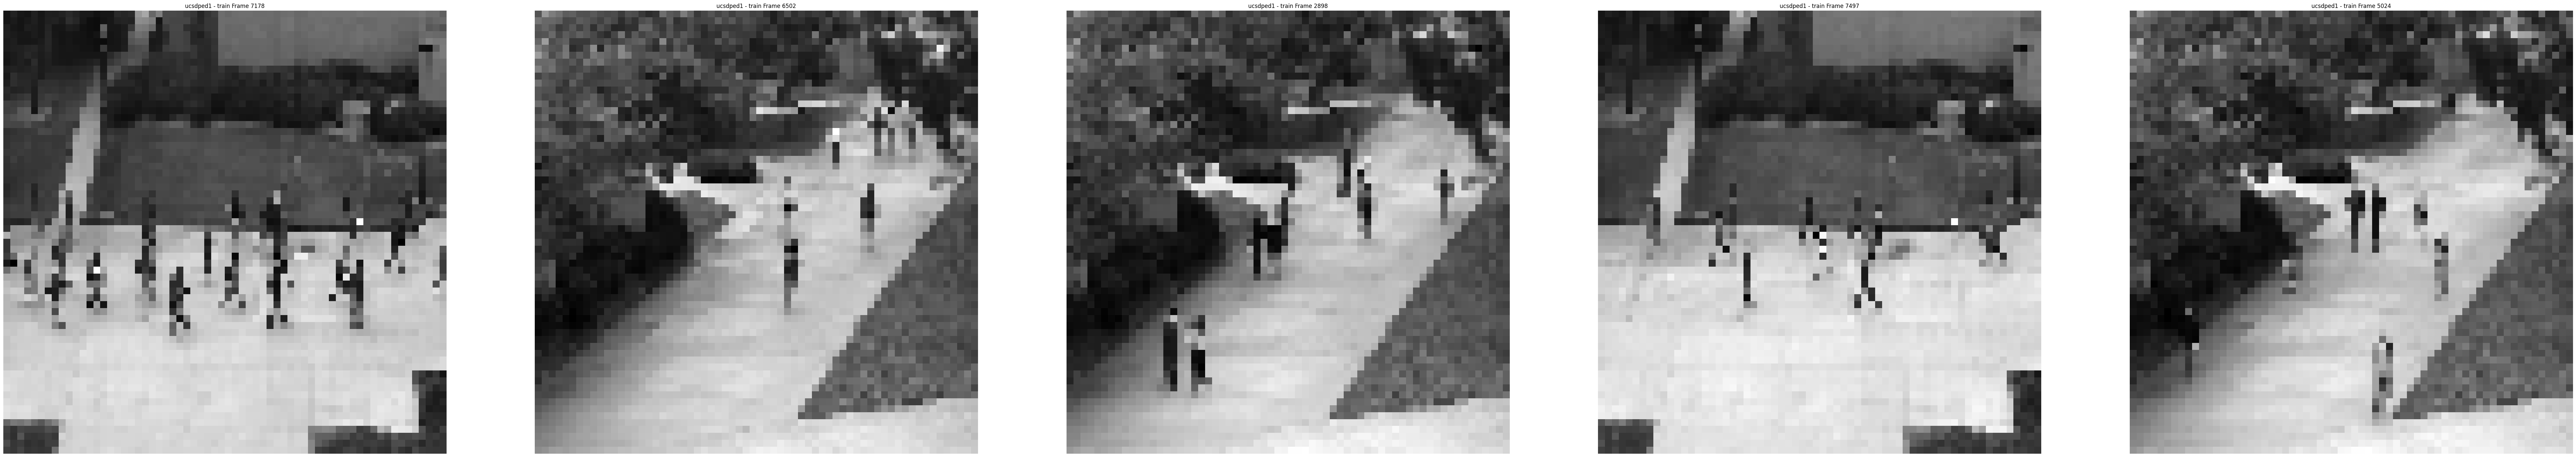

In [3]:
import matplotlib.pyplot as plt
import random

def visualize_frames(data, dataset_name, subset, num_frames=5):
    plt.figure(figsize=(100, 100))
    selected_frames = random.sample(range(len(data)), num_frames)  # Select random frame indices
    
    for i, frame_idx in enumerate(selected_frames):
        frame = data[frame_idx] 
        
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame, cmap='gray')
        plt.title(f"{dataset_name} - {subset} Frame {frame_idx}")
        plt.axis('off')
    
    plt.show()

# Visualize some frames from ucsdped1 and ucsdped2, train and test sets
visualize_frames(train_data, 'ucsdped1', 'train')
#visualize_frames(test_data, 'ucsdped1', 'test')"visualize_frames(train_data, 'ucsdped2', 'train')
#visualize_frames(test_data, 'ucsdped2', 'test')


In [4]:
def build_autoencoder(input_shape=(64, 64, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = UpSampling2D((2, 2))(x)  # First upsampling, from 8x8 to 16x16
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Second upsampling, from 16x16 to 32x32
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Third upsampling, from 32x32 to 64x64
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Output layer with 64x64 dimensions
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Build and compile the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder


In [5]:
# Train the autoencoder on normal frames
history = autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, validation_split=0.1)


NameError: name 'autoencoder' is not defined

In [ ]:
import numpy as np

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(model, data):
    reconstructions = model.predict(data)
    errors = np.mean(np.square(data - reconstructions), axis=(1, 2, 3))
    return errors

# Calculate reconstruction errors on the test set
test_errors = calculate_reconstruction_errors(autoencoder, test_data)

# Define an anomaly threshold (can be adjusted)
threshold = np.percentile(test_errors, 95)  # Setting threshold to 95th percentile of errors
print("Anomaly threshold:", threshold)

# Identify frames with errors above the threshold as anomalies
anomalies = test_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


In [ ]:
import matplotlib.pyplot as plt

# Plot the reconstruction error across all test frames
plt.figure(figsize=(10, 6))
plt.plot(test_errors, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.xlabel("Frame")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.title("Reconstruction Error across Test Frames")
plt.show()


In [ ]:
def display_anomalous_frames(data, errors, threshold, num_frames=5):
    anomaly_indices = np.where(errors > threshold)[0]
    selected_indices = np.random.choice(anomaly_indices, min(num_frames, len(anomaly_indices)), replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        frame = data[idx]  # Reshape frame to 64x64 for visualization
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame, cmap='gray')
        plt.title(f"Anomalous Frame {idx} - Error: {errors[idx]:.4f}")
        plt.axis('off')
    
    plt.show()

# Display anomalous frames
display_anomalous_frames(test_data, test_errors, threshold)
